In [1]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import random
from typing import List, Tuple, Union
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
from tqdm.auto import tqdm

In [4]:
!conda install scipy=1.5.4

/bin/bash: line 1: conda: command not found


In [5]:
!pip install simcse --no-deps

  Preparing metadata (setup.py) ... done
  Created wheel for simcse: filename=simcse-0.4-py3-none-any.whl size=15012 sha256=43c1d22199dc61f8d469bb9599de59b549de7a868d2f3288d701a1ce24577a83
  Stored in directory: /root/.cache/pip/wheels/73/53/90/52802dc953f897ebf5b27b997b47bf4532e24eaae78ad1bad3
Successfully built simcse


In [6]:
from simcse import SimCSE

In [7]:
# Read from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get Data

In [8]:
sentences = json.load(open('/content/drive/My Drive/text_processing/sport_headlines_20K.json'))

In [30]:
sentences[:10]

['Kevin De Bruyne breaks record with 58 tackles in playoff game',
 'Netherlands win ATP Finals in match point',
 'Mavericks defeats Jazz 126-80',
 'Emma Raducanu wins French Open title',
 'Stephen Curry breaks record with 29 blocks in crucial win',
 'Harry Kane wins Bundesliga tournament',
 'Rams win NFL Playoffs in playoffs',
 'Sadio Mane scored 47 crosses in Liverpool defeat',
 'Team USA advance to US Open after hard-fought victory',
 'Damian Lillard breaks record with 55 blocks in championship final']

# Examine SimCSE Similarity

In [10]:
model = SimCSE("princeton-nlp/unsup-simcse-roberta-base")

tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [20]:
model.encode(sentences[0]).shape

100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


torch.Size([768])

In [33]:
sen1_emb = model.encode(sentences[0])
sen2_emb = model.encode(sentences[9])

100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


In [34]:
# Examine similarity of sample pair
np.dot(sen1_emb, sen2_emb) / (np.linalg.norm(sen1_emb) * np.linalg.norm(sen2_emb))

np.float32(0.6264473)

In [11]:
def create_random_pairs(n: int, num_pairs: int = 1000,
                                allow_duplicates: bool = True, seed: int = 42) -> List[Tuple[int, int]]:
    """
    Create random index pairs efficiently - returns indices only
    Memory efficient for large datasets

    Args:
        n: Number of items (sentences)
        num_pairs: Number of random pairs to generate
        allow_duplicates: Whether to allow the same pair multiple times
        seed: Random seed for reproducibility

    Returns:
        List of tuples containing index pairs
    """
    random.seed(seed)
    np.random.seed(seed)

    pairs = []

    if allow_duplicates:
        # Ultra-efficient: just generate random indices - O(num_pairs)
        for _ in range(num_pairs):
            i = random.randint(0, n - 1)
            j = random.randint(0, n - 1)
            while j == i:  # Ensure different indices
                j = random.randint(0, n - 1)
            pairs.append((i, j))
    else:
        # Efficient sampling without replacement
        max_possible_pairs = n * (n - 1) // 2
        if num_pairs > max_possible_pairs:
            print(f"Warning: Requested {num_pairs} pairs but only {max_possible_pairs} unique pairs possible")
            num_pairs = max_possible_pairs

        used_pairs = set()
        attempts = 0
        max_attempts = num_pairs * 10

        while len(pairs) < num_pairs and attempts < max_attempts:
            i = random.randint(0, n - 1)
            j = random.randint(0, n - 1)
            while j == i:
                j = random.randint(0, n - 1)

            # Ensure consistent ordering
            pair_key = (min(i, j), max(i, j))

            if pair_key not in used_pairs:
                used_pairs.add(pair_key)
                pairs.append((i, j))

            attempts += 1

        if attempts >= max_attempts:
            print(f"Warning: Could only generate {len(pairs)} unique pairs after {max_attempts} attempts")

    return pairs

In [13]:
sentence_pairs = create_random_pairs(20000, num_pairs=1000, allow_duplicates=False)

In [16]:
sentence_pairs[:5]

[(3648, 819), (9012, 8024), (7314, 4572), (3358, 17870), (2848, 19349)]

In [22]:
def compute_similarities_from_index_pairs_simple(sentences: List[str], model,
                                               index_pairs: List[Tuple[int, int]]) -> List[float]:
    """
    Simple version - let SimCSE handle optimization internally
    """
    # Extract all sentence pairs at once
    sentences_1 = [sentences[idx1] for idx1, idx2 in tqdm(index_pairs)]
    sentences_2 = [sentences[idx2] for idx1, idx2 in tqdm(index_pairs)]

    # Get all embeddings at once
    emb1_all = model.encode(sentences_1)
    emb2_all = model.encode(sentences_2)

    # Compute all similarities
    similarities = [
        np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        for emb1, emb2 in zip(emb1_all, emb2_all)
    ]

    return similarities

In [25]:
simcse_similarities = compute_similarities_from_index_pairs_simple(sentences=sentences, model=model, index_pairs=sentence_pairs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:56<00:00,  3.50s/it]


In [26]:
simcse_similarities[:5]

[np.float32(0.350198),
 np.float32(0.37176952),
 np.float32(0.37066177),
 np.float32(0.3736972),
 np.float32(0.3463276)]

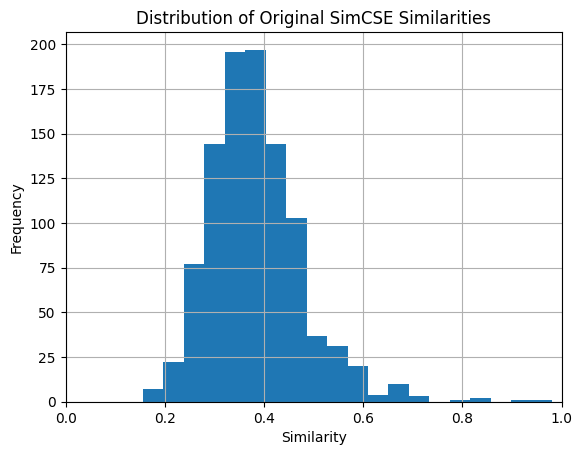

In [46]:
plt.hist(simcse_similarities, bins=20)
plt.grid()
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Original SimCSE Similarities')
plt.xlim(0,1)
plt.show()

# Examine mxbai Embeddings

In [35]:
# Load MXBAI model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("mixedbread-ai/mxbai-embed-large-v1")
model = AutoModel.from_pretrained("mixedbread-ai/mxbai-embed-large-v1")

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

In [38]:
def compute_similarities_from_index_pairs(sentences: List[str], model, tokenizer, device,
                                       index_pairs: List[Tuple[int, int]],
                                       batch_size: int = 100) -> List[float]:
   """
   Compute similarities for given index pairs using MXBAI model (CPU optimized)

   Args:
       sentences: List of all sentences
       model: The MXBAI embedding model
       tokenizer: The tokenizer
       device: Device (cuda/cpu)
       index_pairs: List of (i, j) index tuples
       batch_size: Batch size for processing

   Returns:
       List of similarity scores
   """
   similarities = []

   # Process pairs in batches for memory efficiency
   for i in range(0, len(index_pairs), batch_size):
       batch_pairs = index_pairs[i:i + batch_size]

       # Extract all sentences for this batch
       batch_sentences = []
       for idx1, idx2 in batch_pairs:
           batch_sentences.extend([sentences[idx1], sentences[idx2]])

       # Tokenize all sentences at once
       inputs = tokenizer(batch_sentences, padding=True, truncation=True,
                        return_tensors="pt", max_length=512).to(device)

       with torch.no_grad():
           outputs = model(**inputs)

           # Mean pooling
           attention_mask = inputs['attention_mask']
           token_embeddings = outputs.last_hidden_state
           input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
           sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
           sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
           embeddings = (sum_embeddings / sum_mask).cpu().numpy()

           # Normalize embeddings
           embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

       # Compute similarities for this batch (pairs are at even/odd indices)
       for j in range(0, len(embeddings), 2):
           emb1 = embeddings[j]
           emb2 = embeddings[j + 1]
           similarity = np.dot(emb1, emb2)  # Already normalized, so dot product = cosine similarity
           similarities.append(similarity)

   return similarities

In [40]:
mxbai_similarities = compute_similarities_from_index_pairs(
    sentences=sentences,
    model=model,
    tokenizer=tokenizer,
    device='cpu',
    index_pairs=sentence_pairs,
)

In [41]:
mxbai_similarities[:5]

[np.float32(0.5875244),
 np.float32(0.48516524),
 np.float32(0.59118146),
 np.float32(0.4042007),
 np.float32(0.5925919)]

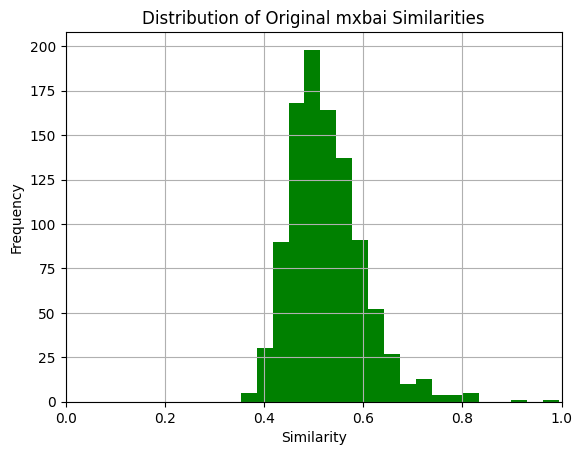

In [47]:
plt.hist(mxbai_similarities, bins=20, color='g')
plt.grid()
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Original mxbai Similarities')
plt.xlim(0,1)
plt.show()